In [ ]:
# These exercises are from https://www.pgexercises.com/
# Practice on these exercises using both SQL and pandas

In [7]:
import pandas as pd
import numpy as np
import psycopg2
import datetime
import time


Open SQL to get tables

In [8]:
#Open Session

conn = psycopg2.connect("dbname=exercises user=postgres")
cur = conn.cursor()


In [9]:
# Check the relations in the db

cur.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
print cur.fetchall()

[('facilities',), ('bookings',), ('members',)]


In [10]:
# Test Query

query = '''SELECT * FROM cd.facilities;'''
cur.execute(query)
cur.fetchone()

(0,
 'Tennis Court 1',
 Decimal('5'),
 Decimal('25'),
 Decimal('10000'),
 Decimal('200'))

In [11]:
# Read Tables into Pandas

qry = 'Select * from cd.members;'
members_df = pd.read_sql(qry, conn)

qry = 'Select * from cd.facilities;'
facilities_df = pd.read_sql(qry, conn)

qry = 'Select * from cd.bookings;'
bookings_db = pd.read_sql(qry, conn)


In [12]:
facilities_df

,facid,name,membercost,guestcost,initialoutlay,monthlymaintenance
0,0,Tennis Court 1,5.0,25.0,10000.0,200.0
1,1,Tennis Court 2,5.0,25.0,8000.0,200.0
2,2,Badminton Court,0.0,15.5,4000.0,50.0
3,3,Table Tennis,0.0,5.0,320.0,10.0
4,4,Massage Room 1,35.0,80.0,4000.0,3000.0
5,5,Massage Room 2,35.0,80.0,4000.0,3000.0
6,6,Squash Court,3.5,17.5,5000.0,80.0
7,7,Snooker Table,0.0,5.0,450.0,15.0
8,8,Pool Table,0.0,5.0,400.0,15.0


In [17]:
bookings_db.head()

,bookid,facid,memid,starttime,slots
0,0,3,1,2012-07-03 11:00:00,2
1,1,4,1,2012-07-03 08:00:00,2
2,2,6,0,2012-07-03 18:00:00,2
3,3,7,1,2012-07-03 19:00:00,2
4,4,8,1,2012-07-03 10:00:00,1


In [5]:
conn.rollback()

NameError: name 'conn' is not defined

In [ ]:
conn.close()

Time for Pandas Fun!!!!

In [13]:
# Aggregation - Exercise #1: For our first foray into aggregates, we're going to stick to something simple. 
#                            We want to know how many facilities exist - simply produce a total count.

facilities_df['facid'].count()

# SQL Version:   
# SELECT COUNT(facilities.facid)
# FROM cd.facilities;

9

In [14]:
# Aggregation - Exercise #2: Produce a count of the number of facilities that have a cost to guests of 10 or more.


facilities_df[facilities_df['guestcost'] > 10]['facid'].count()

# SQL Version:   
# SELECT COUNT(facilities.facid)
# 	FROM cd.facilities
# 	WHERE facilities.guestcost > 10;

6

In [333]:
# Aggregation - Exercise #3:  Produce a count of the number of recommendations each member has made. 
#                             Order by member ID.


# recoms = dict(members_df['recommendedby'].value_counts())
# def rec_counts(df, recom=recoms):
#     if df['memid'] in recom.keys():
    
#         return df['memid'] , recoms[df['memid']]


# members_df.apply(rec_counts, axis=1).dropna().apply(pd.Series, index=[ "id", "no. of recs"]).sort_values(by='id',ascending=True)


# hehehehe, a quicker way using 'pivot'

# pd.pivot_table(members_df, index='recommendedby',aggfunc='count')['memid'].apply(pd.Series, index=[  "no. of recs"])

# groupby

members_df.groupby('recommendedby')['memid'].agg('count')

# SQL
# SELECT m.recommendedby, count(m.recommendedby)
# 	FROM cd.members m
# 	WHERE m.recommendedby IS NOT NULL
# 	GROUP BY m.recommendedby
# 	ORDER BY m.recommendedby;

recommendedby
1.0     5
2.0     3
3.0     1
4.0     2
5.0     1
6.0     1
9.0     2
11.0    1
13.0    2
15.0    1
16.0    1
20.0    1
30.0    1
Name: memid, dtype: int64

In [41]:
members_df['combined_name']

0                 GUEST GUEST
1                Darren Smith
2                 Tracy Smith
3                  Tim Rownam
4             Janice Joplette
5              Gerald Butters
6                Burton Tracy
7                  Nancy Dare
8                  Tim Boothe
9             Ponder Stibbons
10               Charles Owen
11                David Jones
12                 Anne Baker
13             Jemima Farrell
14                 Jack Smith
15             Florence Bader
16              Timothy Baker
17               David Pinker
18            Matthew Genting
19             Anna Mackenzie
20                Joan Coplin
21           Ramnaresh Sarwin
22              Douglas Jones
23           Henrietta Rumney
24              David Farrell
25    Henry Worthington-Smyth
26          Millicent Purview
27        Hyacinth Tupperware
28                  John Hunt
29              Erica Crumpet
30               Darren Smith
Name: combined_name, dtype: object

In [32]:
recoms.keys()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, 11.0, 13.0, 15.0, 16.0, 20.0, 30.0]

In [41]:
# Aggregation - Exercise #4: Produce a list of the total number of slots booked per facility. 
#                            For now, just produce an output table consisting of facility id and 
#                            slots, sorted by facility id.


bookings_db[['facid','slots']].groupby('facid').agg([ 'sum'])

# SQL Version:   
# SELECT b.facid, SUM(b.slots) as "Total Slots"
# 	FROM cd.bookings b
# 	GROUP BY b.facid
# 	ORDER BY b.facid;

,slots
,sum
facid,
0,1320
1,1278
2,1209
3,830
4,1404
5,228
6,1104
7,908


In [34]:
# members_df.pivot(index='recommendedby')
pd.pivot_table(members_df, index='recommendedby',aggfunc='count')['memid']

recommendedby
1.0     5
2.0     3
3.0     1
4.0     2
5.0     1
6.0     1
9.0     2
11.0    1
13.0    2
15.0    1
16.0    1
20.0    1
30.0    1
Name: memid, dtype: int64

In [106]:
# Aggregation - Exercise #5:  Produce a list of the total number of slots booked per facility 
#                             in the month of September 2012. Produce an output table consisting of 
#                             facility id and slots, sorted by the number of slots.


bookings_db[ (pd.to_datetime(bookings_db['starttime']) >= datetime.date(2012,9,1)) & \
          ( pd.to_datetime(bookings_db['starttime']) < datetime.date(2012,10,1) )\
           ][['facid','slots']].groupby('facid').agg(['sum']).apply(lambda x: x.order(ascending=True))

# SQL Version:   
# SELECT b.facid, SUM(b.slots) as "Total Slots"
# 	FROM cd.bookings b
# 	WHERE 
# 		b.starttime >= '2012-09-01' AND
# 		b.starttime < '2012-10-01'
# 	GROUP BY b.facid
# 	ORDER BY "Total Slots";

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: order is deprecated, use sort_values(...)


,slots
,sum
facid,
5,122
3,422
7,426
8,471
6,540
2,570
1,588
0,591


In [105]:
lala.apply(lambda x: x.order(ascending=True))

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


,slots
,sum
facid,
5,122
3,422
7,426
8,471
6,540
2,570
1,588
0,591


In [229]:
# Aggregation - Exercise #6: Produce a list of the total number of slots booked per facility per month
#                          in the year of 2012. Produce an output table consisting of facility id and 
#                          slots, sorted by the id and month.

bookings_db['month'] = pd.to_datetime(bookings_db['starttime']).apply(lambda x: x.month)
bookings_db.groupby(['facid', 'month']).agg(['sum'])['slots']


# SQL Version:   
#   SELECT b.facid, EXTRACT(month FROM b.starttime) as "month", SUM(b.slots) as "Total Slots"
# 	FROM cd.bookings b
# 	WHERE b.starttime >= '2012-01-01' AND
# 		 b.starttime < '2013-01-01'
# 	GROUP BY b.facid, "month"
# 	ORDER BY b.facid, "month";

sum
facid month     
0     7      270
      8      459
      9      591
1     7      207
      8      483
      9      588
2     7      180
      8      459
      9      570
3     7      104
      8      304
      9      422
4     7      264
      8      492
      9      648
5     7       24
      8       82
      9      122
6     7      164
      8      400
      9      540
7     7      156
      8      326
      9      426
8     1        1
      7      117
      8      322
      9      471

In [114]:
pd.to_datetime(bookings_db['starttime'][0]).month

7

In [126]:
# Aggregation - Exercise #7:  Find the total number of members who have made at least one booking.



cnt = bookings_db.groupby(['memid']).agg(['count'])['bookid']
len(cnt[cnt['count']>=1])


# SQL Version: 
# SELECT COUNT(DISTINCT b.memid) 
# 	FROM cd.bookings b;

30

In [239]:
# Aggregation - Exercise #8: Produce a list of facilities with more than 1000 slots booked. 
#                            Produce an output table consisting of facility id and hours, sorted by facility id.


bookings_db['hours'] = bookings_db['slots']/2.0
la = bookings_db[['facid','hours']].groupby('facid').agg(['sum'])
la[la>500].dropna()

# SQL Version: 
# SELECT B.FACID, SUM(b.slots) AS "Total Hours"
# 	FROM cd.bookings b
# 	Group by b.facid
# 	HAVING SUM(b.slots) > 1000
# 	Order by b.facid;

,hours
,sum
facid,
0,660.0
1,639.0
2,604.5
4,702.0
6,552.0


In [166]:
# Aggregation - Exercise #9:  Produce a list of facilities along with their total revenue. 
#                             The output table should consist of facility name and revenue, 
#                             sorted by revenue. Remember that there's a different cost for guests and members!

merged1 = pd.merge(facilities_df, bookings_db, on='facid')
merged1['total cost'] = merged1.apply(lambda x:  x['guestcost']*x['slots']  if x['memid']== 0 else\
                                                     x['membercost']*x['slots'] , axis=1)
merged1.groupby('name')['total cost'].agg(['sum'])


# SQL Version: 
# SELECT f.name, SUM(
# 		CASE
# 			WHEN b.memid = 0 THEN b.slots*f.guestcost
#   			ELSE b.slots*f.membercost
#   		END) AS cost
# 	FROM
# 		cd.bookings b INNER JOIN cd.facilities f
# 		ON b.facid = f.facid
# 	GROUP BY f.name
# 	ORDER BY cost;

,sum
name,
Badminton Court,1906.5
Massage Room 1,72540.0
Massage Room 2,15810.0
Pool Table,270.0
Snooker Table,240.0
Squash Court,13468.0
Table Tennis,180.0
Tennis Court 1,13860.0
Tennis Court 2,14310.0


In [163]:
# Aggregates - Exercise #10:  Produce a list of facilities with a total revenue less than 1000. 
#                         Produce an output table consisting of facility name and revenue, 
#                         sorted by revenue. Remember that there's a different cost for guests and members!

# I can take the results from before

_ = merged1.groupby('name').agg(['sum'])['total cost']
_[_ < 1000].dropna()

# SQL Version: 

# SELECT f.name, SUM(
# 		CASE 
# 			WHEN b.memid=0 THEN f.guestcost*b.slots
# 			ELSE f.membercost*b.slots
# 		END) AS revenue
# 	FROM 
# 		cd.bookings b INNER JOIN cd.facilities f
# 		ON b.facid = f.facid
# 	GROUP BY f.name
# 	HAVING SUM(
# 		CASE 
# 			WHEN b.memid=0 THEN f.guestcost*b.slots
# 			ELSE f.membercost*b.slots
# 		END) < 1000
# 	ORDER BY revenue;
	
		

,sum
name,
Pool Table,270.0
Snooker Table,240.0
Table Tennis,180.0


In [203]:
# Aggregates - Exercise #11:  Output the facility id that has the highest number of slots booked. 
#                             For bonus points, try a version without a LIMIT clause. 
#                             This version will probably look messy!

dff= bookings_db.groupby('facid').agg(['sum']).reset_index()
dff.loc[dff['slots'].idxmax()][['facid','slots']]

# SQL Version: 

# select facid, sum(slots) as totalslots
# 	from cd.bookings
# 	group by facid
# 	having sum(slots) = (select max(sum2.totalslots) from
# 		(select sum(slots) as totalslots
# 		from cd.bookings
# 		group by facid
# 		) as sum2);

# or Using CTE (Common Table Expression)

# with sum as (select facid, sum(slots) as totalslots
# 	from cd.bookings
# 	group by facid
# )
# select facid, totalslots 
# 	from sum
# 	where totalslots = (select max(totalslots) from sum);

,facid,slots
,,sum
4,4,1404


In [231]:
# Aggregates - Exercise #12:   Produce a list of the total number of slots booked per facility per 
#                              month in the year of 2012. In this version, include output rows containing 
#                              totals for all months per facility, and a total for all months for all 
#                              facilities. The output table should consist of facility id, month and slots, 
#                              sorted by the id and month. When calculating the aggregated values for all
#                              months and all facids, return null values in the month and facid columns.

# In pandas, I have to get the month value from the date, then groupby month and facid; 
#in addition I need columns for totals

bookings_db2 = bookings_db\
[(pd.to_datetime(bookings_db['starttime']) >= datetime.date(2012,1,1)) & (pd.to_datetime(bookings_db['starttime']) < datetime.date(2013,1,1))]\
.pivot_table(index=['month'], columns=['facid'], values=['slots'], aggfunc='sum', margins=True)
bookings_db2.dropna() #.unstack(level='month')


# SQL Version: 
# SELECT b.facid, EXTRACT(month from b.starttime) as month, SUM(b.slots)
# 	FROM cd.bookings b
# 	WHERE b.starttime >= '2012-01-01' AND
# 		  b.starttime < '2013-01-01'
# 	GROUP BY ROLLUP(b.facid, month)
# 	ORDER BY b.facid, month;

slots                                                              \
facid       0       1       2      3       4      5       6      7      8   
month                                                                       
7       270.0   207.0   180.0  104.0   264.0   24.0   164.0  156.0  117.0   
8       459.0   483.0   459.0  304.0   492.0   82.0   400.0  326.0  322.0   
9       591.0   588.0   570.0  422.0   648.0  122.0   540.0  426.0  471.0   
All    1320.0  1278.0  1209.0  830.0  1404.0  228.0  1104.0  908.0  910.0   

               
facid     All  
month          
7      1486.0  
8      3327.0  
9      4378.0  
All    9191.0

In [240]:
# Aggregates - Exercise #13:  Produce a list of the total number of hours booked per facility, 
#                             remembering that a slot lasts half an hour. The output table should 
#                             consist of the facility id, name, and hours booked, sorted by facility id. 
#                             Try formatting the hours to two decimal places.


merged = pd.merge(bookings_db,facilities_df, on='facid')
merged.groupby(['facid', 'name']).agg(['sum'])['hours']

# SQL 
# SELECT b.facid, f.name, TRIM(TO_CHAR(SUM(b.slots/2.0),'99999D99')) AS "Total Hours"
# 	FROM cd.bookings b INNER JOIN cd.facilities f
# 	ON b.facid = f.facid
	
# 	GROUP BY b.facid, f.name
# 	ORDER BY b.facid;

,,sum
facid,name,
0,Tennis Court 1,660.0
1,Tennis Court 2,639.0
2,Badminton Court,604.5
3,Table Tennis,415.0
4,Massage Room 1,702.0
5,Massage Room 2,114.0
6,Squash Court,552.0
7,Snooker Table,454.0
8,Pool Table,455.5


In [263]:
stringy = '2024-12-29 11:06:29'
yingy = '1972-12-29 11:06:29'
ying = pd.to_datetime(yingy)
strin = pd.to_datetime(stringy)
(ying - strin).days/365.25

pd.concat([members_df.head(), members_df.tail()], axis=0)

,memid,surname,firstname,address,zipcode,telephone,recommendedby,joindate
0,0,GUEST,GUEST,GUEST,0,(000) 000-0000,NaN,2012-07-01 00:00:00
1,1,Smith,Darren,"8 Bloomsbury Close, Boston",4321,555-555-5555,NaN,2012-07-02 12:02:05
2,2,Smith,Tracy,"8 Bloomsbury Close, New York",4321,555-555-5555,NaN,2012-07-02 12:08:23
3,3,Rownam,Tim,"23 Highway Way, Boston",23423,(844) 693-0723,NaN,2012-07-03 09:32:15
4,4,Joplette,Janice,"20 Crossing Road, New York",234,(833) 942-4710,1.0,2012-07-03 10:25:05
26,30,Purview,Millicent,"641 Drudgery Close, Burnington, Boston",34232,(855) 941-9786,2.0,2012-09-18 19:04:01
27,33,Tupperware,Hyacinth,"33 Cheerful Plaza, Drake Road, Westford",68666,(822) 665-5327,NaN,2012-09-18 19:32:05
28,35,Hunt,John,"5 Bullington Lane, Boston",54333,(899) 720-6978,30.0,2012-09-19 11:32:45
29,36,Crumpet,Erica,"Crimson Road, North Reading",75655,(811) 732-4816,2.0,2012-09-22 08:36:38
30,37,Smith,Darren,"3 Funktown, Denzington, Boston",66796,(822) 577-3541,NaN,2012-09-26 18:08:45


In [255]:
members_df[members_df['joindate'] >= datetime.date(2012,8,25)]['memid'].nunique()

12

In [57]:
# Aggregates - Exercise #14:  Produce a list of each member name, id, and their first booking after 
#                             September 1st 2012. Order by member ID.






# SQL 
# 
# SELECT bks.starttime as start, fcs.name as name
# 	FROM 
# 		cd.bookings bks INNER JOIN cd.facilities fcs
# 		ON bks.facid = fcs.facid
# 	WHERE bks.starttime >= '2012-09-21' AND bks.starttime < '2012-09-22'
# 	AND fcs.name LIKE '%Tennis Court%'
	
#   ORDER BY bks.starttime;

,starttime,name1
3360,2012-09-21 08:00:00,Tennis Court 1
3366,2012-09-21 08:00:00,Tennis Court 2
3361,2012-09-21 09:30:00,Tennis Court 1
3367,2012-09-21 10:00:00,Tennis Court 2
3368,2012-09-21 11:30:00,Tennis Court 2
3362,2012-09-21 12:00:00,Tennis Court 1
3363,2012-09-21 13:30:00,Tennis Court 1
3369,2012-09-21 14:00:00,Tennis Court 2
3364,2012-09-21 15:30:00,Tennis Court 1
3370,2012-09-21 16:00:00,Tennis Court 2


In [ ]:
# Joins and Subqueries  - Exercise #2:   How can you output a list of all members who have recommended
#                                        another member? Ensure that there are no duplicates in the list, 
#                                        and that results are ordered by (surname, firstname).

members_df[['surname', 'firstname']][members_df['memid'].isin(list(members_df['recommendedby'])) ].sort_values(['surname', 'firstname'])


# SQL

# SELECT DISTINCT mb2.surname, mb2.firstname
# 	FROM 
#     	cd.members mb1 INNER JOIN cd.members mb2
#         ON mb2.memid = mb1.recommendedby
#     ORDER BY mb2.surname, mb2.firstname;

In [22]:
# Joins and Subqueries  - Exercise #4: How can you output a list of all members, including the individual 
#                         who recommended them (if any)? 
#                         Ensure that results are ordered by (surname, firstname).

pd.merge(members_df, members_df, how='left', right_on='memid', left_on='recommendedby')[['firstname_x', 'surname_x', 'firstname_y', 'surname_y']]


# SQL

# SELECT mb1.firstname as memfname, mb1.surname as memsname, mb2.firstname as recfname, mb2.surname as recsname
# 	FROM 
#      	cd.members mb1 LEFT OUTER JOIN cd.members mb2
#          ON mb2.memid = mb1.recommendedby
#      ORDER BY mb1.surname, mb1.firstname;

,firstname_x,surname_x,firstname_y,surname_y
0,GUEST,GUEST,NaN,NaN
1,Darren,Smith,NaN,NaN
2,Tracy,Smith,NaN,NaN
3,Tim,Rownam,NaN,NaN
4,Janice,Joplette,Darren,Smith
5,Gerald,Butters,Darren,Smith
6,Burton,Tracy,NaN,NaN
7,Nancy,Dare,Janice,Joplette
8,Tim,Boothe,Tim,Rownam
9,Ponder,Stibbons,Burton,Tracy


In [35]:
members_df['combined_name'] = members_df['firstname']+' ' +members_df['surname']
members_df['combined_name']

0                 GUEST GUEST
1                Darren Smith
2                 Tracy Smith
3                  Tim Rownam
4             Janice Joplette
5              Gerald Butters
6                Burton Tracy
7                  Nancy Dare
8                  Tim Boothe
9             Ponder Stibbons
10               Charles Owen
11                David Jones
12                 Anne Baker
13             Jemima Farrell
14                 Jack Smith
15             Florence Bader
16              Timothy Baker
17               David Pinker
18            Matthew Genting
19             Anna Mackenzie
20                Joan Coplin
21           Ramnaresh Sarwin
22              Douglas Jones
23           Henrietta Rumney
24              David Farrell
25    Henry Worthington-Smyth
26          Millicent Purview
27        Hyacinth Tupperware
28                  John Hunt
29              Erica Crumpet
30               Darren Smith
Name: combined_name, dtype: object

In [93]:
merge2['starttime'][0].date()

datetime.date(2012, 7, 3)

In [38]:
# Joins and Subqueries  - Exercise #5:  How can you produce a list of all members who have used a tennis court? 
#                                       Include in your output the name of the court, and the name of the
#                                       member formatted as a single column. 
#                                       Ensure no duplicate data, and order by the member name.

merge1 = pd.merge(members_df,bookings_db, on= 'memid')
merge2 = pd.merge(merge1, facilities_df, on='facid')
np.sort(merge2[merge2['name'].str.contains('Tennis C')]['combined_name'].unique())


# SQL

# SELECT DISTINCT CONCAT(m.firstname, ' ',m.surname) as member, f.name as facility
# 	FROM 
#     	cd.members m INNER JOIN cd.bookings b
#         ON m.memid = b.memid
#         INNER JOIN cd.facilities f
#         ON f.facid = b.facid
        
#         WHERE f.name LIKE 'Tennis C%'
        
#         ORDER BY member;

array(['Anne Baker', 'Burton Tracy', 'Charles Owen', 'Darren Smith',
       'David Farrell', 'David Jones', 'David Pinker', 'Douglas Jones',
       'Erica Crumpet', 'Florence Bader', 'GUEST GUEST', 'Gerald Butters',
       'Henrietta Rumney', 'Jack Smith', 'Janice Joplette',
       'Jemima Farrell', 'Joan Coplin', 'John Hunt', 'Matthew Genting',
       'Millicent Purview', 'Nancy Dare', 'Ponder Stibbons',
       'Ramnaresh Sarwin', 'Tim Boothe', 'Tim Rownam', 'Timothy Baker',
       'Tracy Smith'], dtype=object)

In [125]:
# Joins and Subqueries  - Exercise #6: How can you produce a list of bookings on the day of 2012-09-14 
#                                      which will cost the member (or guest) 
#                                      more than $30? Remember that guests have different costs to members 
#                                      (the listed costs are per half-hour 'slot'), and the guest user
#                                      is always ID 0. Include in your output the name of the facility, 
#                                      the name of the member formatted as a single column, and the cost. 
#                                      Order by descending cost, and do not use any subqueries.


def cost(df):
    costg = df['slots']*df['guestcost']
    costm = df['slots']*df['membercost']
    if 'GUEST' in df['firstname'] and costg>30 and  (df['starttime'].date()>= datetime.date(2012,9,14) ) and ( df['starttime'].date() < datetime.date(2012,9,15) ) :
        return df['name'], df['combined_name'], costg
    elif 'GUEST' not in df['firstname'] and costm>30 and (df['starttime'].date()>= datetime.date(2012,9,14) ) and ( df['starttime'].date() < datetime.date(2012,9,15) )  :
        return df['name'], df['combined_name'], costm
    else: pass

cheap_expensive = merge2.apply(cost, axis=1).dropna()
cheap_expensive.apply(pd.Series, index=["facility", "name", "cost"]).sort_values(by='cost',ascending=False)

# lambda x:'oop' if  x['firstname'].str.contains("GUEST"), axis=1)
# merge2['firstname'].str.contains("GUEST")

# SQL 

# SELECT CONCAT(m.firstname, ' ', m.surname) as member, f.name as facility, 
# 	CASE
#     	WHEN m.memid = 0 THEN b.slots*f.guestcost
#         ELSE b.slots*f.membercost
#     END as cost
    
#     FROM cd.members m INNER JOIN cd.bookings b
#     ON m.memid = b.memid
#     INNER JOIN cd.facilities f
#     ON f.facid = b.facid
    
#     WHERE b.starttime >= '2012-09-14' AND 
#           b.starttime < '2012-09-15' AND (
#           (m.memid != 0 AND b.slots*f.membercost > 30) OR 
#           (m.memid = 0 AND b.slots*f.guestcost > 30)
#     )
#     ORDER BY cost DESC;

,facility,name,cost
2750,Massage Room 2,GUEST GUEST,320.0
594,Massage Room 1,GUEST GUEST,160.0
595,Massage Room 1,GUEST GUEST,160.0
596,Massage Room 1,GUEST GUEST,160.0
1157,Tennis Court 2,GUEST GUEST,150.0
963,Massage Room 1,Jemima Farrell,140.0
1535,Tennis Court 1,GUEST GUEST,75.0
1534,Tennis Court 1,GUEST GUEST,75.0
1156,Tennis Court 2,GUEST GUEST,75.0
1038,Massage Room 1,Matthew Genting,70.0


In [129]:
# Joins and Subqueries  - Exercise #7:    How can you output a list of all members, including the individual
#                                         who recommended them (if any), without using any joins? Ensure that 
#                                         there are no duplicates in the list, and that each firstname + surname 
#                                         pairing is formatted as a column and ordered.


result1 = pd.merge(members_df,members_df,left_on='recommendedby', right_on='memid')[['combined_name_x', 'combined_name_y']].sort_values('combined_name_x')
result1.columns = ['member', 'recommender']
result1


# SQL 

# SELECT DISTINCT CONCAT(members.firstname, ' ' , members.surname) as name,
# 		(
# 		  SELECT CONCAT(recs.firstname, ' ', recs.surname) as recommender
# 				  FROM cd.members recs
# 		  		  WHERE recs.memid = members.recommendedby)
# 		FROM cd.members
# 		ORDER BY name;

,member,recommender
4,Anna Mackenzie,Darren Smith
9,Anne Baker,Ponder Stibbons
2,Charles Owen,Darren Smith
6,David Jones,Janice Joplette
12,David Pinker,Jemima Farrell
16,Douglas Jones,David Jones
20,Erica Crumpet,Tracy Smith
10,Florence Bader,Ponder Stibbons
1,Gerald Butters,Darren Smith
17,Henrietta Rumney,Matthew Genting


In [130]:
# Joins and Subqueries  - Exercise #8: The Produce a list of costly bookings exercise contained some 
#                                      messy logic: we had to calculate the booking cost in both the 
#                                      WHERE clause and the CASE statement. Try to simplify this 
#                                      calculation using subqueries. For reference, the question was:
#  
#                                      How can you produce a list of bookings on the day of 2012-09-14 
#                                      which will cost the member (or guest) more than $30? Remember 
#                                      that guests have different costs to members (the listed costs are 
#                                      per half-hour 'slot'), and the guest user is always ID 0. Include 
#                                      in your output the name of the facility, the name of the member 
#                                      formatted as a single column, and the cost. Order by descending cost.

# for pandas, I just pasted the solution from above

def cost(df):
    costg = df['slots']*df['guestcost']
    costm = df['slots']*df['membercost']
    if 'GUEST' in df['firstname'] and costg>30 and  (df['starttime'].date()>= datetime.date(2012,9,14) ) and ( df['starttime'].date() < datetime.date(2012,9,15) ) :
        return df['name'], df['combined_name'], costg
    elif 'GUEST' not in df['firstname'] and costm>30 and (df['starttime'].date()>= datetime.date(2012,9,14) ) and ( df['starttime'].date() < datetime.date(2012,9,15) )  :
        return df['name'], df['combined_name'], costm
    else: pass

cheap_expensive = merge2.apply(cost, axis=1).dropna()
cheap_expensive.apply(pd.Series, index=["facility", "name", "cost"]).sort_values(by='cost',ascending=False)



# SQL

# SELECT member, facility, cost
# 	FROM (
#         SELECT CONCAT(m.firstname, ' ' , m.surname) as member,
#                f.name as facility,
#         	   CASE
#         			WHEN m.memid = 0 THEN f.guestcost*b.slots
#         			ELSE f.membercost*b.slots
#         	   END as cost
        
#         FROM 
#         	   cd.bookings b INNER JOIN cd.members m
#         	   ON b.memid = m.memid
#         	   INNER JOIN cd.facilities f
#         	   ON f.facid = b.facid
        
#         WHERE 
#                b.starttime >= '2012-09-14' AND
#         	   b.starttime < '2012-09-15'
#         ) as bookings
        
#        WHERE 
#         	cost > 30
        
#        ORDER BY cost DESC;

,facility,name,cost
2750,Massage Room 2,GUEST GUEST,320.0
594,Massage Room 1,GUEST GUEST,160.0
595,Massage Room 1,GUEST GUEST,160.0
596,Massage Room 1,GUEST GUEST,160.0
1157,Tennis Court 2,GUEST GUEST,150.0
963,Massage Room 1,Jemima Farrell,140.0
1535,Tennis Court 1,GUEST GUEST,75.0
1534,Tennis Court 1,GUEST GUEST,75.0
1156,Tennis Court 2,GUEST GUEST,75.0
1038,Massage Room 1,Matthew Genting,70.0


In [ ]:
facilities_df['name'][facilities_df['facid'] == bookings_db['facid'][4]].to_string(index=False)

In [ ]:
bookings_db['facid'][10]

In [ ]:
members_df[(members_df['firstname']=='David') & (members_df['surname']=='Farrell')]['memid']

In [ ]:
datetime.date(2017,9,1)

In [ ]:
f = lambda x: 1 if x>0 else 0 if x ==0 else -1

In [ ]:
facilities_df["cost"] = np.where(facilities_df["monthlymaintenance"] < 100, "Cheap", "Expensive")

In [ ]:
members_df


In [ ]:
bookings_db

In [ ]:
np.where([[True, False], [True, True]],[[1, 2], [3, 4]],[[9, 8], [7, 6]])

In [ ]:
facilities_df = facilities_df.drop('cost', axis=1)

In [264]:
# eda with bookings

In [312]:
boodb = bookings_db.sort_values('starttime').copy()


In [325]:
boodb.head()

,bookid,facid,memid,starttime,slots,name1,month,hours,between_times
1,1,4,1,2012-07-03 08:00:00,2,Massage Room 1,7,1.0,0.0
4,4,8,1,2012-07-03 10:00:00,1,Pool Table,7,0.5,2.0
0,0,3,1,2012-07-03 11:00:00,2,Table Tennis,7,1.0,1.0
5,5,8,1,2012-07-03 15:00:00,1,Pool Table,7,0.5,4.0
2,2,6,0,2012-07-03 18:00:00,2,Squash Court,7,1.0,3.0


In [323]:
boodb['between_times'] = between_times

In [326]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline
sns.set()

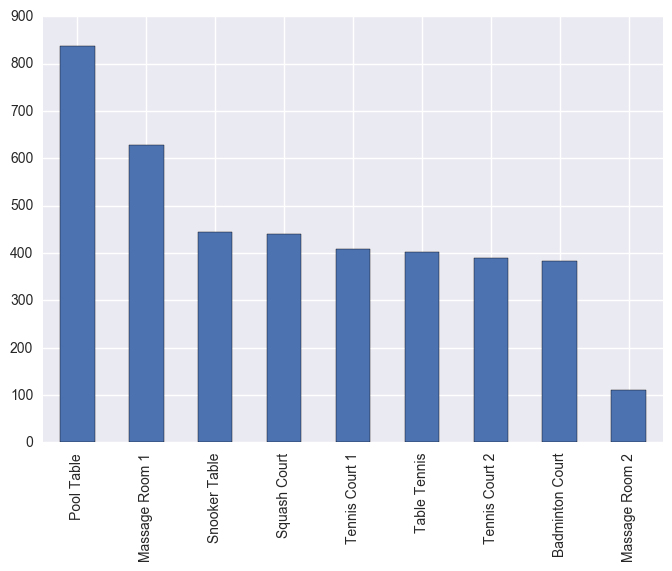

In [270]:
bookings_db['name1'].value_counts().plot(kind='bar')

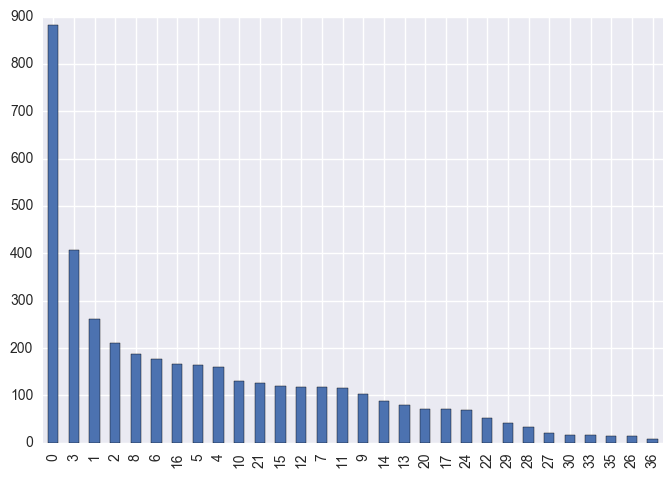

In [276]:
bvc = bookings_db['memid'].value_counts()
bvc.plot(kind='bar')

In [277]:
def ecdf(data):
    n_data = len(data) # number of points
    x = np.sort(data) # x-data
    y = np.arange(1, n_data+1)/ float(n_data)
    return x, y
    

In [283]:
# convert starttimes to days between events
starttimes = list(bookings_db['starttime'])

In [302]:
starttimes

[Timestamp('2012-07-03 08:00:00'),
 Timestamp('2012-07-03 10:00:00'),
 Timestamp('2012-07-03 11:00:00'),
 Timestamp('2012-07-03 15:00:00'),
 Timestamp('2012-07-03 18:00:00'),
 Timestamp('2012-07-03 19:00:00'),
 Timestamp('2012-07-04 09:00:00'),
 Timestamp('2012-07-04 12:00:00'),
 Timestamp('2012-07-04 12:30:00'),
 Timestamp('2012-07-04 13:30:00'),
 Timestamp('2012-07-04 14:00:00'),
 Timestamp('2012-07-04 14:00:00'),
 Timestamp('2012-07-04 15:00:00'),
 Timestamp('2012-07-04 15:00:00'),
 Timestamp('2012-07-04 15:30:00'),
 Timestamp('2012-07-04 17:30:00'),
 Timestamp('2012-07-04 18:00:00'),
 Timestamp('2012-07-05 09:00:00'),
 Timestamp('2012-07-05 09:30:00'),
 Timestamp('2012-07-05 12:30:00'),
 Timestamp('2012-07-05 13:00:00'),
 Timestamp('2012-07-05 14:30:00'),
 Timestamp('2012-07-05 17:30:00'),
 Timestamp('2012-07-05 18:30:00'),
 Timestamp('2012-07-05 18:30:00'),
 Timestamp('2012-07-05 19:00:00'),
 Timestamp('2012-07-06 08:00:00'),
 Timestamp('2012-07-06 08:30:00'),
 Timestamp('2012-07-

In [321]:
between_times = [(starttimes[i]-starttimes[i-1]).seconds/3600.0 for i,x in enumerate(starttimes) if i !=0]
between_times = [0]+between_times

In [322]:
between_times

[0,
 2.0,
 1.0,
 4.0,
 3.0,
 1.0,
 14.0,
 3.0,
 0.5,
 1.0,
 0.5,
 0.0,
 1.0,
 0.0,
 0.5,
 2.0,
 0.5,
 15.0,
 0.5,
 3.0,
 0.5,
 1.5,
 3.0,
 1.0,
 0.0,
 0.5,
 13.0,
 0.5,
 2.5,
 1.0,
 1.5,
 0.5,
 0.0,
 1.5,
 0.0,
 1.5,
 15.5,
 0.0,
 0.0,
 0.5,
 1.5,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.5,
 0.5,
 0.0,
 1.5,
 0.0,
 0.0,
 1.5,
 0.0,
 16.5,
 1.0,
 0.0,
 0.5,
 1.5,
 1.0,
 1.0,
 1.5,
 0.0,
 0.0,
 1.0,
 0.0,
 0.5,
 0.5,
 0.0,
 1.0,
 0.0,
 13.5,
 0.5,
 1.5,
 1.5,
 0.5,
 1.5,
 0.0,
 1.0,
 0.0,
 1.0,
 0.5,
 1.5,
 0.0,
 0.5,
 0.0,
 0.0,
 1.0,
 12.0,
 0.5,
 0.0,
 1.5,
 1.0,
 0.5,
 0.0,
 0.0,
 0.5,
 2.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 1.0,
 0.5,
 12.5,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.5,
 0.5,
 1.0,
 0.0,
 0.0,
 1.0,
 0.5,
 0.5,
 0.5,
 0.5,
 1.5,
 1.0,
 12.5,
 1.0,
 2.5,
 0.5,
 1.5,
 0.0,
 2.5,
 0.0,
 0.5,
 0.0,
 1.5,
 0.5,
 13.5,
 1.0,
 0.5,
 1.0,
 0.5,
 0.0,
 1.5,
 1.0,
 0.5,
 1.0,
 0.0,
 0.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 1.0,
 13.5,
 0.5,
 0.0,
 0.5,
 0.5,
 1.0,
 1.0,
 1.0,
 

In [328]:
x,y = ecdf(between_times)

x_theor, y_theor = ecdf(np.random.exponential(np.mean(between_times), 10000))

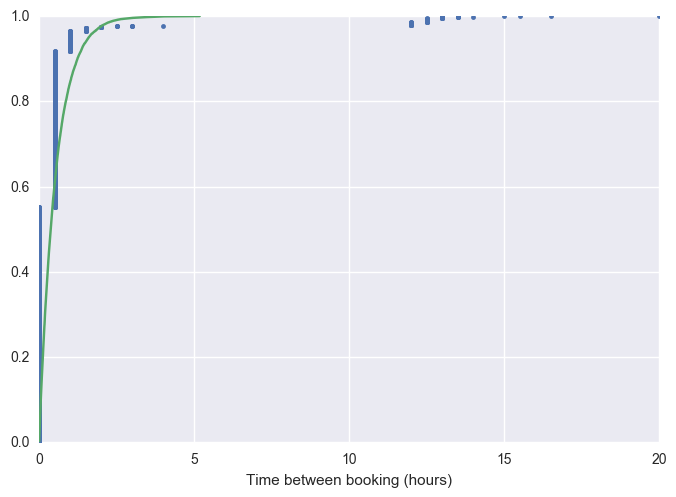

In [329]:
plt.plot(x,y, marker='.', linestyle='none')
_ = plt.xlabel('Time between booking (hours)')
plt.plot(x_theor,y_theor)

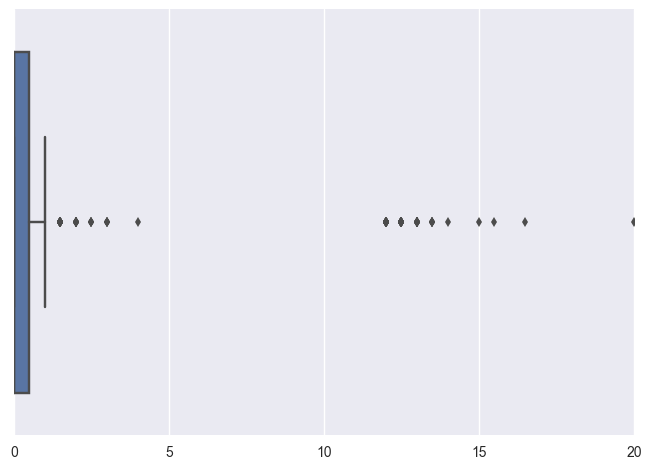

In [308]:
sns.boxplot(between_times)

(array([  3.93400000e+03,   1.80000000e+01,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          8.50000000e+01,   3.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.]),
 <a list of 10 Patch objects>)

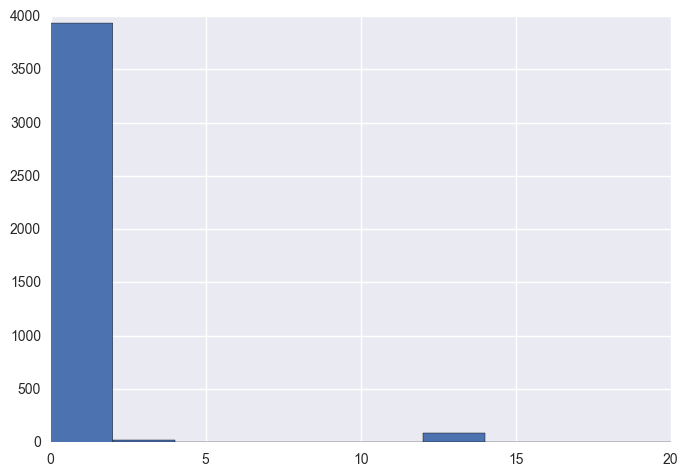

In [309]:
plt.hist(between_times)